<a href="https://colab.research.google.com/github/liamchalcroft/RectAngle/blob/main/colab_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook for basic prototyping of work before porting to full script for testing

Note: Try importing lambda layer

In [1]:
! git clone https://49064dc98b2d46c3874378ed4375bf1b5938d905@github.com/liamchalcroft/RectAngle.git

Cloning into 'RectAngle'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [2]:
! python ./RectAngle/data.py

Done.
Image and label data downloaded: dataset70-200.h5
  with 200 cases with a total of 5346 frames and 16038 labels.

How many example frames would you like to visualise, e.g. 10?
0


In [3]:
import h5py
import matplotlib.pyplot as plt
from torch import nn
import torch
import random
import numpy as np

In [4]:
f = h5py.File('dataset70-200.h5', 'r')

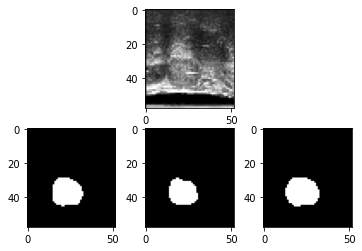

In [5]:
plt.figure()
plt.subplot(2,3,2)
plt.imshow(f['frame_0000_000'], cmap='gray')
plt.subplot(2,3,4)
plt.imshow(f['label_0000_000_00'], cmap='gray')
plt.subplot(2,3,5)
plt.imshow(f['label_0000_000_01'], cmap='gray')
plt.subplot(2,3,6)
plt.imshow(f['label_0000_000_02'], cmap='gray')
plt.show()

In [196]:
class UNetBlock(nn.Module):
  def __init__(self, ch_in, n_feat, device='cpu'):

    super().__init__()

    self.conv1 = torch.nn.Sequential(
        nn.Conv2d(in_channels=ch_in, out_channels=n_feat, 
                  kernel_size=3, padding=1, bias=False).to(device),
        nn.ReLU(inplace=True).to(device),
        nn.BatchNorm2d(num_features=n_feat).to(device))
    
    self.conv2 = torch.nn.Sequential(
        nn.Conv2d(in_channels=n_feat, out_channels=n_feat, 
                  kernel_size=3, padding=1, bias=False).to(device),
        nn.ReLU(inplace=True).to(device),
        nn.BatchNorm2d(num_features=n_feat).to(device)
        )
    
    self.conv1.to(device)
    self.conv2.to(device)
    

  def forward(self, x):
    x = self.conv1(x)
    x = x + self.conv2(x)
    return x


class UNet(nn.Module):
  def __init__(self, device='cpu', ch_in=1, ch_out=1,
               first_layer=16, n_layers=4):
    
    super().__init__()

    self.device = device
    
    enc_list = []
    down_list = []

    enc_list.append(UNetBlock(ch_in, first_layer, device).to(device))
    down_list.append(nn.MaxPool2d(kernel_size=2, stride=2).to(device))

    for i in range(n_layers-1):
      enc_list.append(UNetBlock(first_layer*(2**i), 
                                          first_layer*(2**(i+1)),
                                     device).to(device))
      down_list.append(nn.MaxPool2d(kernel_size=2, stride=2).to(device))

    self.enc_list = nn.ModuleList(enc_list)
    self.down_list = nn.ModuleList(down_list)
      
    self.bottleneck = UNetBlock(first_layer*(2**(n_layers-1)),
                                     first_layer*(2**(n_layers)),
                                     device).to(device)

    dec_list = []
    up_list = []

    for i in range(n_layers):
      up_list.append(nn.ConvTranspose2d(first_layer*(2**(n_layers-(i))), 
                                        first_layer*(2**(n_layers-(i+1))), 
                                        kernel_size=2, stride=2).to(device))
      dec_list.append(UNetBlock(first_layer*(2**(n_layers-(i))), 
                                     first_layer*(2**(n_layers-(i+1))),
                                     device).to(device))
      
    self.dec_list = nn.ModuleList(dec_list)
    self.up_list = nn.ModuleList(up_list)
      
    self.head = nn.Conv2d(in_channels=first_layer, out_channels=ch_out, 
                          kernel_size=1).to(device)
    
    self.enc_list.to(device)
    self.down_list.to(device)
    self.bottleneck.to(device)
    self.dec_list.to(device)
    self.up_list.to(device)
    self.head.to(device)
    
    
  def forward(self, x):
    # pad images to (64,64)
    shape = list(x.shape)
    shape[2] = shape[3] = 64
    pad_x = torch.zeros(shape)
    pad_x[:,:,:58,:52] = x
    x = pad_x.to(self.device)

    enc_features = []
    for i in range(len(self.enc_list)):
      x = self.enc_list[i](x)
      enc_features.append(x)
      x = self.down_list[i](x)
    
    x = self.bottleneck(x)

    enc_features = enc_features[::-1]

    for i in range(len(self.dec_list)):
      x = self.up_list[i](x)
      x = torch.cat((x, enc_features[i]), dim=1)
      x = self.dec_list[i](x)

    x = self.head(x)

    # crop to original size of (58,52)
    x = x[:,:,:58,:52]
    
    return torch.sigmoid(x)


class DiceLoss(nn.Module):
    # Standard Dice loss, with variable smoothing constant
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.round(inputs)
        targets = torch.round(targets)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = torch.sum(inputs * targets)
        dice = ((2. * intersection) + self.smooth) / \
                (torch.sum(inputs) + torch.sum(targets) + self.smooth)

        return (1 - dice)

In [271]:
def train_val_test(file, ratio=(0.8, 0.2, 0)):
  keys = [key.split('_') for key in file.keys()]
  num_subjects = int(keys[-1][1])
  assert 1.0 * sum(ratio) == 1.0
  sum_ratio = list(ratio)
  if sum_ratio[1] > 0:
    sum_ratio[1] += sum_ratio[0]
  if sum_ratio[2] > 0:
    sum_ratio[2] += sum_ratio[1]
  scaled_ratio = [int(round(val * num_subjects)) for val in sum_ratio]

  ix = np.linspace(0, num_subjects, num_subjects+1, dtype=int)
  train_ix = ix[:scaled_ratio[0]]
  if scaled_ratio[1] > 0:
    val_ix = ix[scaled_ratio[0]:scaled_ratio[1]]
  else:
    val_ix = 0
  if scaled_ratio[2] > 0:
    test_ix = ix[scaled_ratio[1]:scaled_ratio[2]]
  else:
    test_ix = 0

  return train_ix, val_ix, test_ix


def key_gen(file, ix):
  keys = list(file.keys())
  split_keys = [key.split('_') for key in keys]
  new_keys = []

  for i, key in enumerate(split_keys):
    if int(key[1]) in ix:
      new_keys.append(keys[i])

  return new_keys


class H5DataLoader(torch.utils.data.Dataset):
  def __init__(self, file, keys=None):
    
    super().__init__()

    self.file = file
    if not keys:
      keys = list(file.keys())
    split_keys = [key.split('_') for key in keys]
    start_subj = int(split_keys[0][1])
    last_subj = int(split_keys[-1][1])
    self.num_subjects = last_subj - start_subj
    self.subjects = np.linspace(start_subj, last_subj, 
                                self.num_subjects+1, dtype=int)
    num_frames = []
    for subj in range(start_subj, last_subj):
      subj_string = str(subj).zfill(4)
      frames = [key[2] for key in split_keys if key[1] == subj_string]
      num_frames.append(int(frames[-1]))

    self.num_frames = num_frames

  def __len__(self):
        return self.num_subjects
  
  def __getitem__(self, index):
    subj_ix = self.subjects[index]
    frame_ix = random.randint(0, self.num_frames[index])
    label_ix = random.randint(0, 2)
    image = torch.unsqueeze(torch.tensor(
        self.file['frame_%04d_%03d' % (subj_ix, 
                                       frame_ix
                                       )][()].astype('float32')), dim=0)
    label = torch.unsqueeze(torch.tensor(
        self.file['label_%04d_%03d_%02d' % (subj_ix, 
                                            frame_ix, 
                                            label_ix
                                            )][()].astype('float32')), dim=0)
    return(image, label)

In [272]:
model = UNet(n_layers=4, device='cuda')

In [273]:
# print(model)

In [274]:
# ! pip install lambda-networks

In [275]:
# Either figure out lambda import or write from scratch based on holocron code

In [276]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  torch.backends.cudnn.benchmark = True
else:
  device = torch.device('cpu')

model = UNet(n_layers=3, device=device)

In [312]:
train_ix, val_ix, _ = train_val_test(f)

train_keys, val_keys = key_gen(f, train_ix), key_gen(f, val_ix)

train_data, val_data = H5DataLoader(f, train_keys), H5DataLoader(f, val_keys)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, 
                                           shuffle=True, num_workers=0)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, 
                                         shuffle=True, num_workers=0)

In [313]:
dice_loss = DiceLoss()

dice_val = DiceLoss(smooth=0)

optim = torch.optim.Adam(model.parameters())

In [314]:
nb_epoch = 100
val_interval = 2

loss_epoch = []
loss_log = []
dice_log = []

In [315]:
for epoch in range(nb_epoch):
  for (input, label) in train_loader:
    input, label = input.to(device), label.to(device)

    optim.zero_grad()
    pred = model(input)
    loss = dice_loss(pred, label)
    loss.backward()
    optim.step()

    loss_epoch.append(loss.item())

  mean_loss = np.mean(loss_epoch)
  loss_log.append(mean_loss)
  print('Epoch #{}: Mean Dice Loss: {}'.format(epoch, mean_loss))

  if epoch % val_interval == 0:
    with torch.no_grad():
      for input, label in val_loader:
        input, label = input.to(device), label.to(device)

        pred = model(input)
        dice_metric = dice_val(pred, label)
        dice_metric = 1 - dice_metric.item()

    dice_log.append(dice_metric)
    print('Mean Validation Dice: {}'.format(dice_metric))

print('\nTraining Complete')

Epoch #0: Mean Dice Loss: 0.789190948009491
Mean Validation Dice: 0.31962621212005615
Epoch #1: Mean Dice Loss: 0.7724069952964783
Epoch #2: Mean Dice Loss: 0.7721060911814371
Mean Validation Dice: 0.27520322799682617
Epoch #3: Mean Dice Loss: 0.7706146985292435
Epoch #4: Mean Dice Loss: 0.7772668421268463
Mean Validation Dice: 0.25110924243927
Epoch #5: Mean Dice Loss: 0.7769165088733038
Epoch #6: Mean Dice Loss: 0.7771379351615906
Mean Validation Dice: 0.05518299341201782
Epoch #7: Mean Dice Loss: 0.7777713611721992
Epoch #8: Mean Dice Loss: 0.7777251866128709
Mean Validation Dice: 0.1288454532623291
Epoch #9: Mean Dice Loss: 0.7761658132076263
Epoch #10: Mean Dice Loss: 0.7751109870997342
Mean Validation Dice: 0.11548364162445068
Epoch #11: Mean Dice Loss: 0.7744557981689771
Epoch #12: Mean Dice Loss: 0.7734167048564324
Mean Validation Dice: 0.24243378639221191
Epoch #13: Mean Dice Loss: 0.772016601903098
Epoch #14: Mean Dice Loss: 0.7721433818340302
Mean Validation Dice: 0.20312368

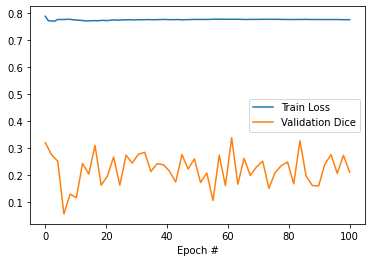

In [320]:
plt.figure()
plt.plot(np.linspace(0,nb_epoch,nb_epoch), loss_log)
plt.plot(np.linspace(0,nb_epoch,nb_epoch//2), dice_log)
plt.xlabel('Epoch #')
plt.legend(['Train Loss', 'Validation Dice'])
plt.show()